In [15]:
import gzip
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy as np
import string
import random
import string
import json
from nltk.stem import PorterStemmer
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield json.loads(l)

In [3]:
users_reviews = [l for l in parse("review-Hawaii_10.json.gz")]
businesses = [l for l in parse("meta-Hawaii.json.gz")]

### Feature Engineering

In [4]:
#user avg rating
user_ratings = {}

for review in users_reviews:
    user_id = review.get('user_id')
    rating = review.get('rating')

    if user_id is not None and rating is not None:
        if user_id not in user_ratings:
            user_ratings[user_id] = {'total_rating': 0, 'count': 0}
        
        user_ratings[user_id]['total_rating'] += rating
        user_ratings[user_id]['count'] += 1

user_avg_ratings = {user_id: data['total_rating'] / data['count'] 
                    for user_id, data in user_ratings.items() if data['count'] > 0}

for user_id in list(user_avg_ratings.keys())[:5]:
    print(f"User ID: {user_id}, Average Rating: {user_avg_ratings[user_id]:.2f}")

User ID: 113965417079576625433, Average Rating: 4.91
User ID: 116655819137293331166, Average Rating: 4.73
User ID: 100834119994550070853, Average Rating: 4.94
User ID: 103207214144482097315, Average Rating: 4.64
User ID: 108526171163172578599, Average Rating: 3.48


In [5]:
#businuess img count
image_counts = {}

for review in users_reviews:
    gmap_id = review.get('gmap_id')
    images = review.get('pics')

    if gmap_id and images:
        num_images = len(images)
        if gmap_id in image_counts:
            image_counts[gmap_id] += num_images
        else:
            image_counts[gmap_id] = num_images

In [6]:
response_counts = {}

for review in users_reviews:
    gmap_id = review.get('gmap_id')
    response = review.get('resp')

    if gmap_id and response:
        if gmap_id in response_counts:
            response_counts[gmap_id] += 1
        else:
            response_counts[gmap_id] = 1

In [7]:
users_data = [{'user_id': d['user_id'], 'gmap_id': d['gmap_id'], 'rating': d['rating'],'text': d['text']} 
              for d in users_reviews if 'user_id' in d and 'gmap_id' in d and 'rating' in d and 'text' in d]

business_dict = {d['gmap_id']: {'avg_rating': d.get('avg_rating', 0), 
                                'num_of_reviews': d.get('num_of_reviews', 0)}
                 for d in businesses if 'gmap_id' in d}

In [8]:
features = [{'user_id': d['user_id'], 'gmap_id': d['gmap_id'], 'text': d['text'], 
             'user_avg_rating': user_avg_ratings[d['user_id']], 
             'response_count': response_counts.get(d['gmap_id'], 0), 
             'image_counts': image_counts.get(d['gmap_id'], 0),
             'bus_avg_rating': business_dict[d['gmap_id']]['avg_rating'], 
             'num_of_reviews': business_dict[d['gmap_id']]['num_of_reviews']}
            for d in users_reviews if 'user_id' in d and 'gmap_id' in d and 'rating' in d and 'text' in d]
labels = [d['rating'] for d in users_reviews if 'user_id' in d and 'gmap_id' in d and 'rating' in d and 'text' in d]
    

In [9]:
random.seed(12345)
combined = list(zip(features, labels))
random.shuffle(combined)
features[:], labels[:] = zip(*combined)

In [10]:
features[0]

{'user_id': '118019878707665188743',
 'gmap_id': '0x7eaad5b76010bf61:0xd3730662460d3b4f',
 'text': 'Absolutely Beautiful! Stunning one of a kind views and Amazing eats! Enjoy!',
 'user_avg_rating': 5.0,
 'response_count': 3,
 'image_counts': 24,
 'bus_avg_rating': 4.2,
 'num_of_reviews': 326}

### Data Visualization

In [16]:
user_avg_ratings = [f['user_avg_rating'] for f in features]
bus_avg_ratings = [f['bus_avg_rating'] for f in features]
num_of_reviews = [f['num_of_reviews'] for f in features]
response_counts = [f['response_count'] for f in features]
image_counts = [f['image_counts'] for f in features]
ratings = [review['rating'] for review in users_reviews if 'rating' in review]

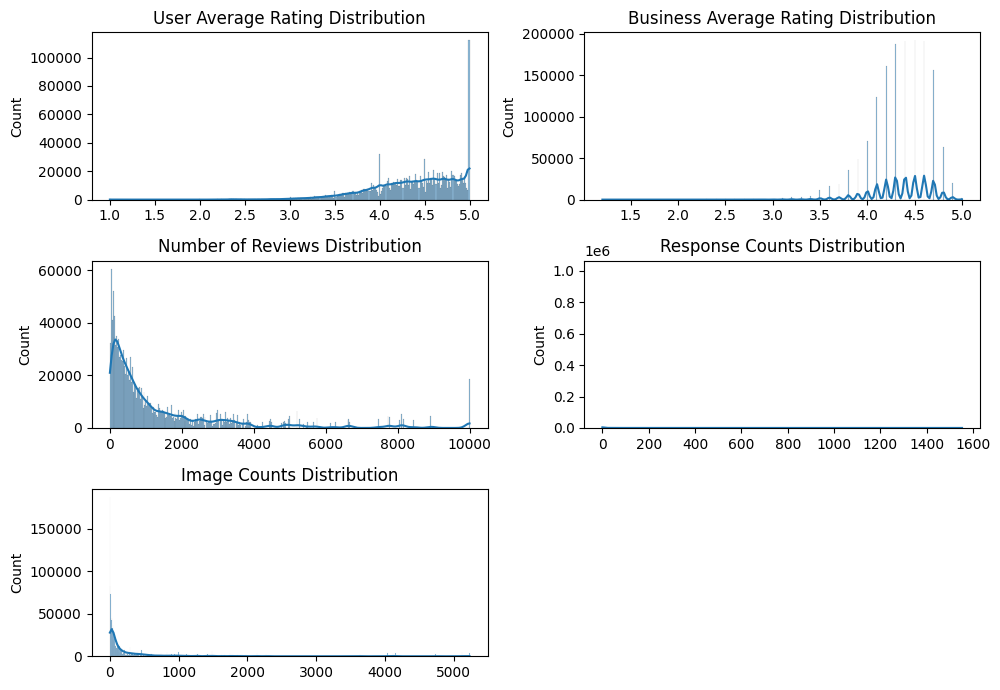

In [25]:
plt.figure(figsize=(10, 7))

plt.subplot(3, 2, 1)
sns.histplot(user_avg_ratings, kde=True)
plt.title('User Average Rating Distribution')

plt.subplot(3, 2, 2)
sns.histplot(bus_avg_ratings, kde=True)
plt.title('Business Average Rating Distribution')

plt.subplot(3, 2, 3)
sns.histplot(num_of_reviews, kde=True)
plt.title('Number of Reviews Distribution')

plt.subplot(3, 2, 4)
sns.histplot(response_counts, kde=True)
plt.title('Response Counts Distribution')

plt.subplot(3, 2, 5)
sns.histplot(image_counts, kde=True)
plt.title('Image Counts Distribution')

plt.tight_layout()
plt.show()

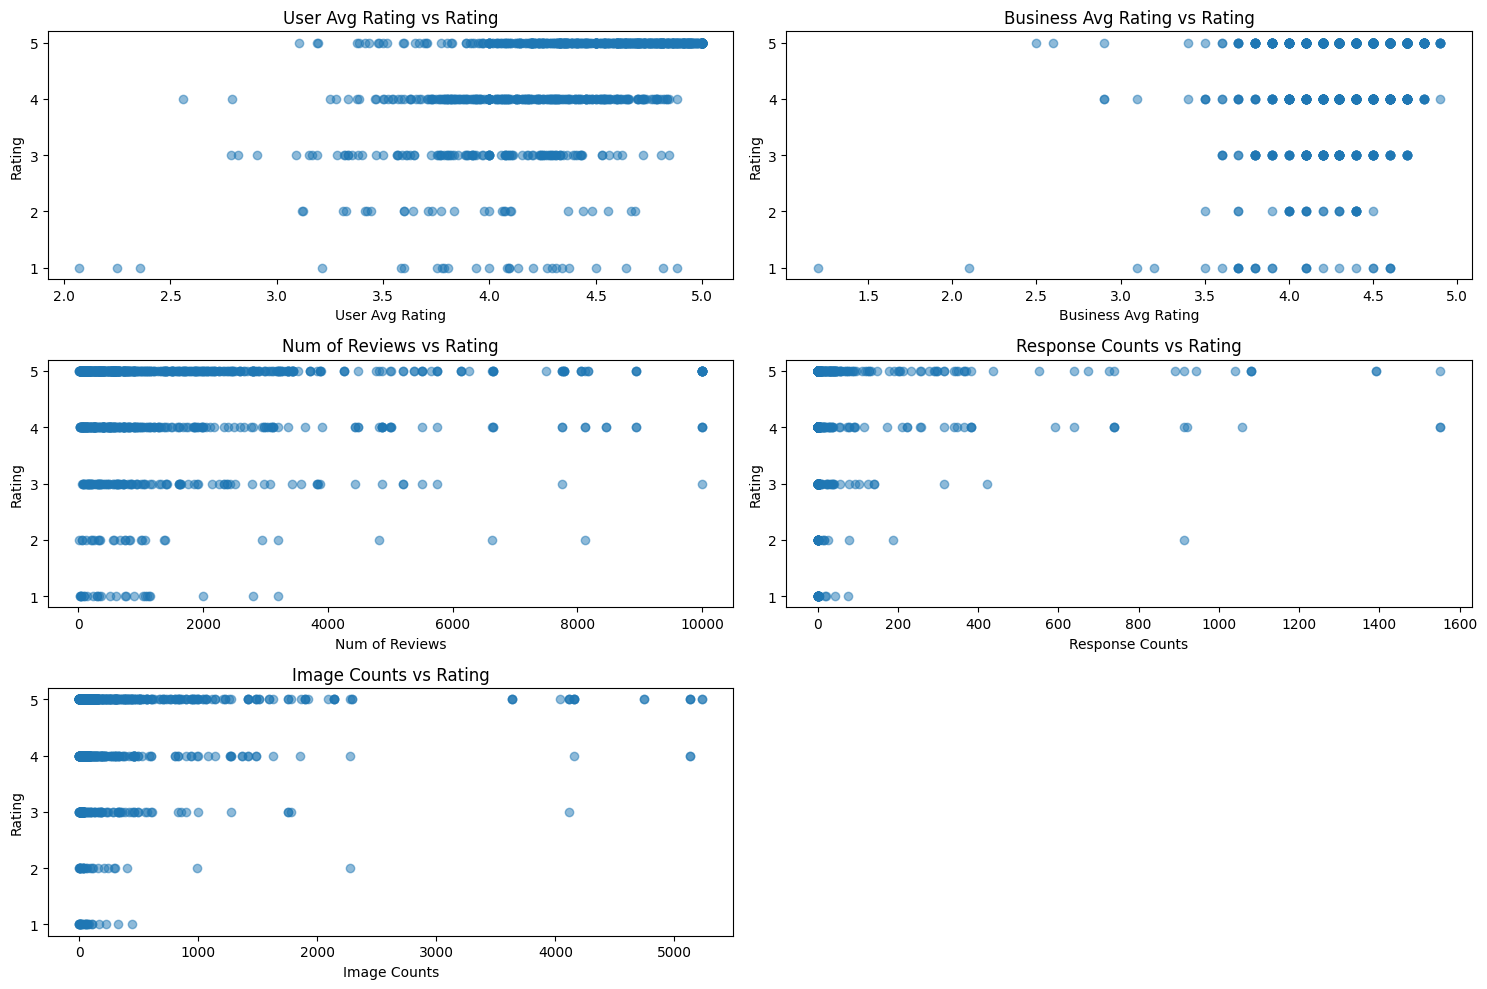

In [22]:
plt.figure(figsize=(15, 10))
for i, (feature, title) in enumerate(zip([user_avg_ratings, bus_avg_ratings, num_of_reviews, response_counts, image_counts], 
                                         ['User Avg Rating', 'Business Avg Rating', 'Num of Reviews', 'Response Counts', 'Image Counts'])):
    plt.subplot(3, 2, i+1)
    plt.scatter(feature[:1000], labels[:1000], alpha=0.5)
    plt.xlabel(title)
    plt.ylabel('Rating')
    plt.title(f'{title} vs Rating')

plt.tight_layout()
plt.show()